In [1]:
### https://anaconda.org/anaconda/py-xgboost
### Importando as libs
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
import pylab as pl
from sklearn import model_selection
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# Scripts

In [2]:
def forward_feature_construction(colunasx,colunasy):
    ### Config
    size = len(colunasx)
    lista = list()
    for id in  range(1,size):
        for x in  combinations(colunasx,r=id):
            lista.append(list(x))
        ### Resampling
    return lista    

In [39]:
def predict(lista, train, colunasy,teste_size,scan):
   
    ### Config Default
    colunas=['Classe','FamiliaQtde','PassagemPreco','SexoNum','SaudacaoNum']
    seed = 9
    max_depth=3
    min_child_weight=3
    
    ### Config Final
    colunas_final=[]
    max_depth_final=0
    seed_final=0
    acertos_final=0
    min_child_weight_final=0
    
    
    resultXGBClassifier=0
    
    if scan:
        for max_depth_it in  range(0,10):
            for seed_it in  range(1,15):
                for colunasx_it in  lista:
                    ### Slice
                    x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunasx_it],train[colunasy],test_size=teste_size,random_state=seed_it)
                    ### Modelo - Treino
                    xgb_model = xgb.XGBClassifier(max_depth=max_depth_it,min_child_weight=min_child_weight_it).fit(x_treino, y_treino)
                    ### Modelo - Predict
                    predictions = xgb_model.predict(x_teste)

                    ### Confusion Matrix
                    actuals = y_teste
                    #print(colunasx)
                    #print(confusion_matrix(actuals, predictions))
                    previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
                    resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
                    resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]

                    if resultadoAcertos.size > acertos:
                        ### Score
                        resultXGBClassifier = xgb_model.score(x_teste,y_teste)
                        ### Resultado Final
                        max_depth_final=max_depth_it
                        seed_final=seed_it
                        colunas_final=colunasx_it
                        acertos_final=resultadoAcertos.size
                        min_child_weight_final=min_child_weight
    else:
        ### Slice
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)
        ### Modelo - Treino
        xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)
        ### Modelo - Predict
        predictions = xgb_model.predict(x_teste)
        ### Score
        resultXGBClassifier = xgb_model.score(x_teste,y_teste)
        actuals = y_teste
        previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
        resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
        resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
        ### Resultado Final
        max_depth_final=max_depth
        seed_final=seed
        colunas_final=colunas
        acertos_final=resultadoAcertos.size
        min_child_weight_final=min_child_weight
                    
    print('Score XGBClassifier:',(resultXGBClassifier*100.0))
    #print('Acertos',resultadoAcertos.size)
    #print('Predict',x_teste_dropna.shape)
    #print('Erros',resultadoErros.shape)
    
    return (acertos_final,colunas_final,seed_final,max_depth_final,min_child_weight_final)


    

# Coleta de dados

## Fontes

In [40]:
### Coletando as fontes de dados
test_csv = pd.read_csv('r_teste.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_csv = pd.read_csv('r_treino.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_dropna_csv = pd.read_csv('r_treino_dropna.csv', sep = ',', encoding = 'UTF-8',header='infer')

In [41]:
train_dropna_csv.head(2)

,PassageiroId,Classe,PortoEmbarqueNum,ParentesIrmao,ParentesFilhos,SexoNum,SaudacaoNum,PassagemPreco,FamiliaQtde,Sobreviventes
0,1,3,1,1,0,1,0,7.2500,1,0
1,2,1,2,1,0,0,1,71.2833,1,1


In [42]:
colunasx=[
    'Classe',
    'PortoEmbarqueNum',
    'ParentesIrmao',
    'ParentesFilhos',
    'FamiliaQtde',
    'PassagemPreco',
    'SexoNum',
    'SaudacaoNum'   
]
colunasy=['Sobreviventes']

In [43]:
colunas = forward_feature_construction(colunasx,colunasy)

In [44]:
#train_dropna_csv=train_dropna_csv.set_index(train_dropna_csv['PassageiroId'])
train= train_dropna_csv
#train= train_csv
train=train.set_index(train['PassageiroId'])

In [45]:
### Config
teste_size=0.30 ##30%

In [46]:
acertos,colunas,seed,max_depth,min_child_weight=predict(colunas, train, colunasy,teste_size,False)

Score XGBClassifier: 81.86046511627907


In [47]:
acertos

176

In [48]:
colunas

['Classe', 'FamiliaQtde', 'PassagemPreco', 'SexoNum', 'SaudacaoNum']

In [49]:
seed

9

In [50]:
max_depth

3

In [51]:
min_child_weight

4

# Resultado Final

In [52]:
x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)

In [53]:
xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)

In [54]:
y_pred_dropna = xgb_model.predict(test_csv[colunas])

In [55]:
submission = pd.DataFrame({
        "PassengerId": test_csv["PassageiroId"],
        "Survived": y_pred_dropna
    })
submission.to_csv('resultXGBClassifier_dropna.csv', index=False)

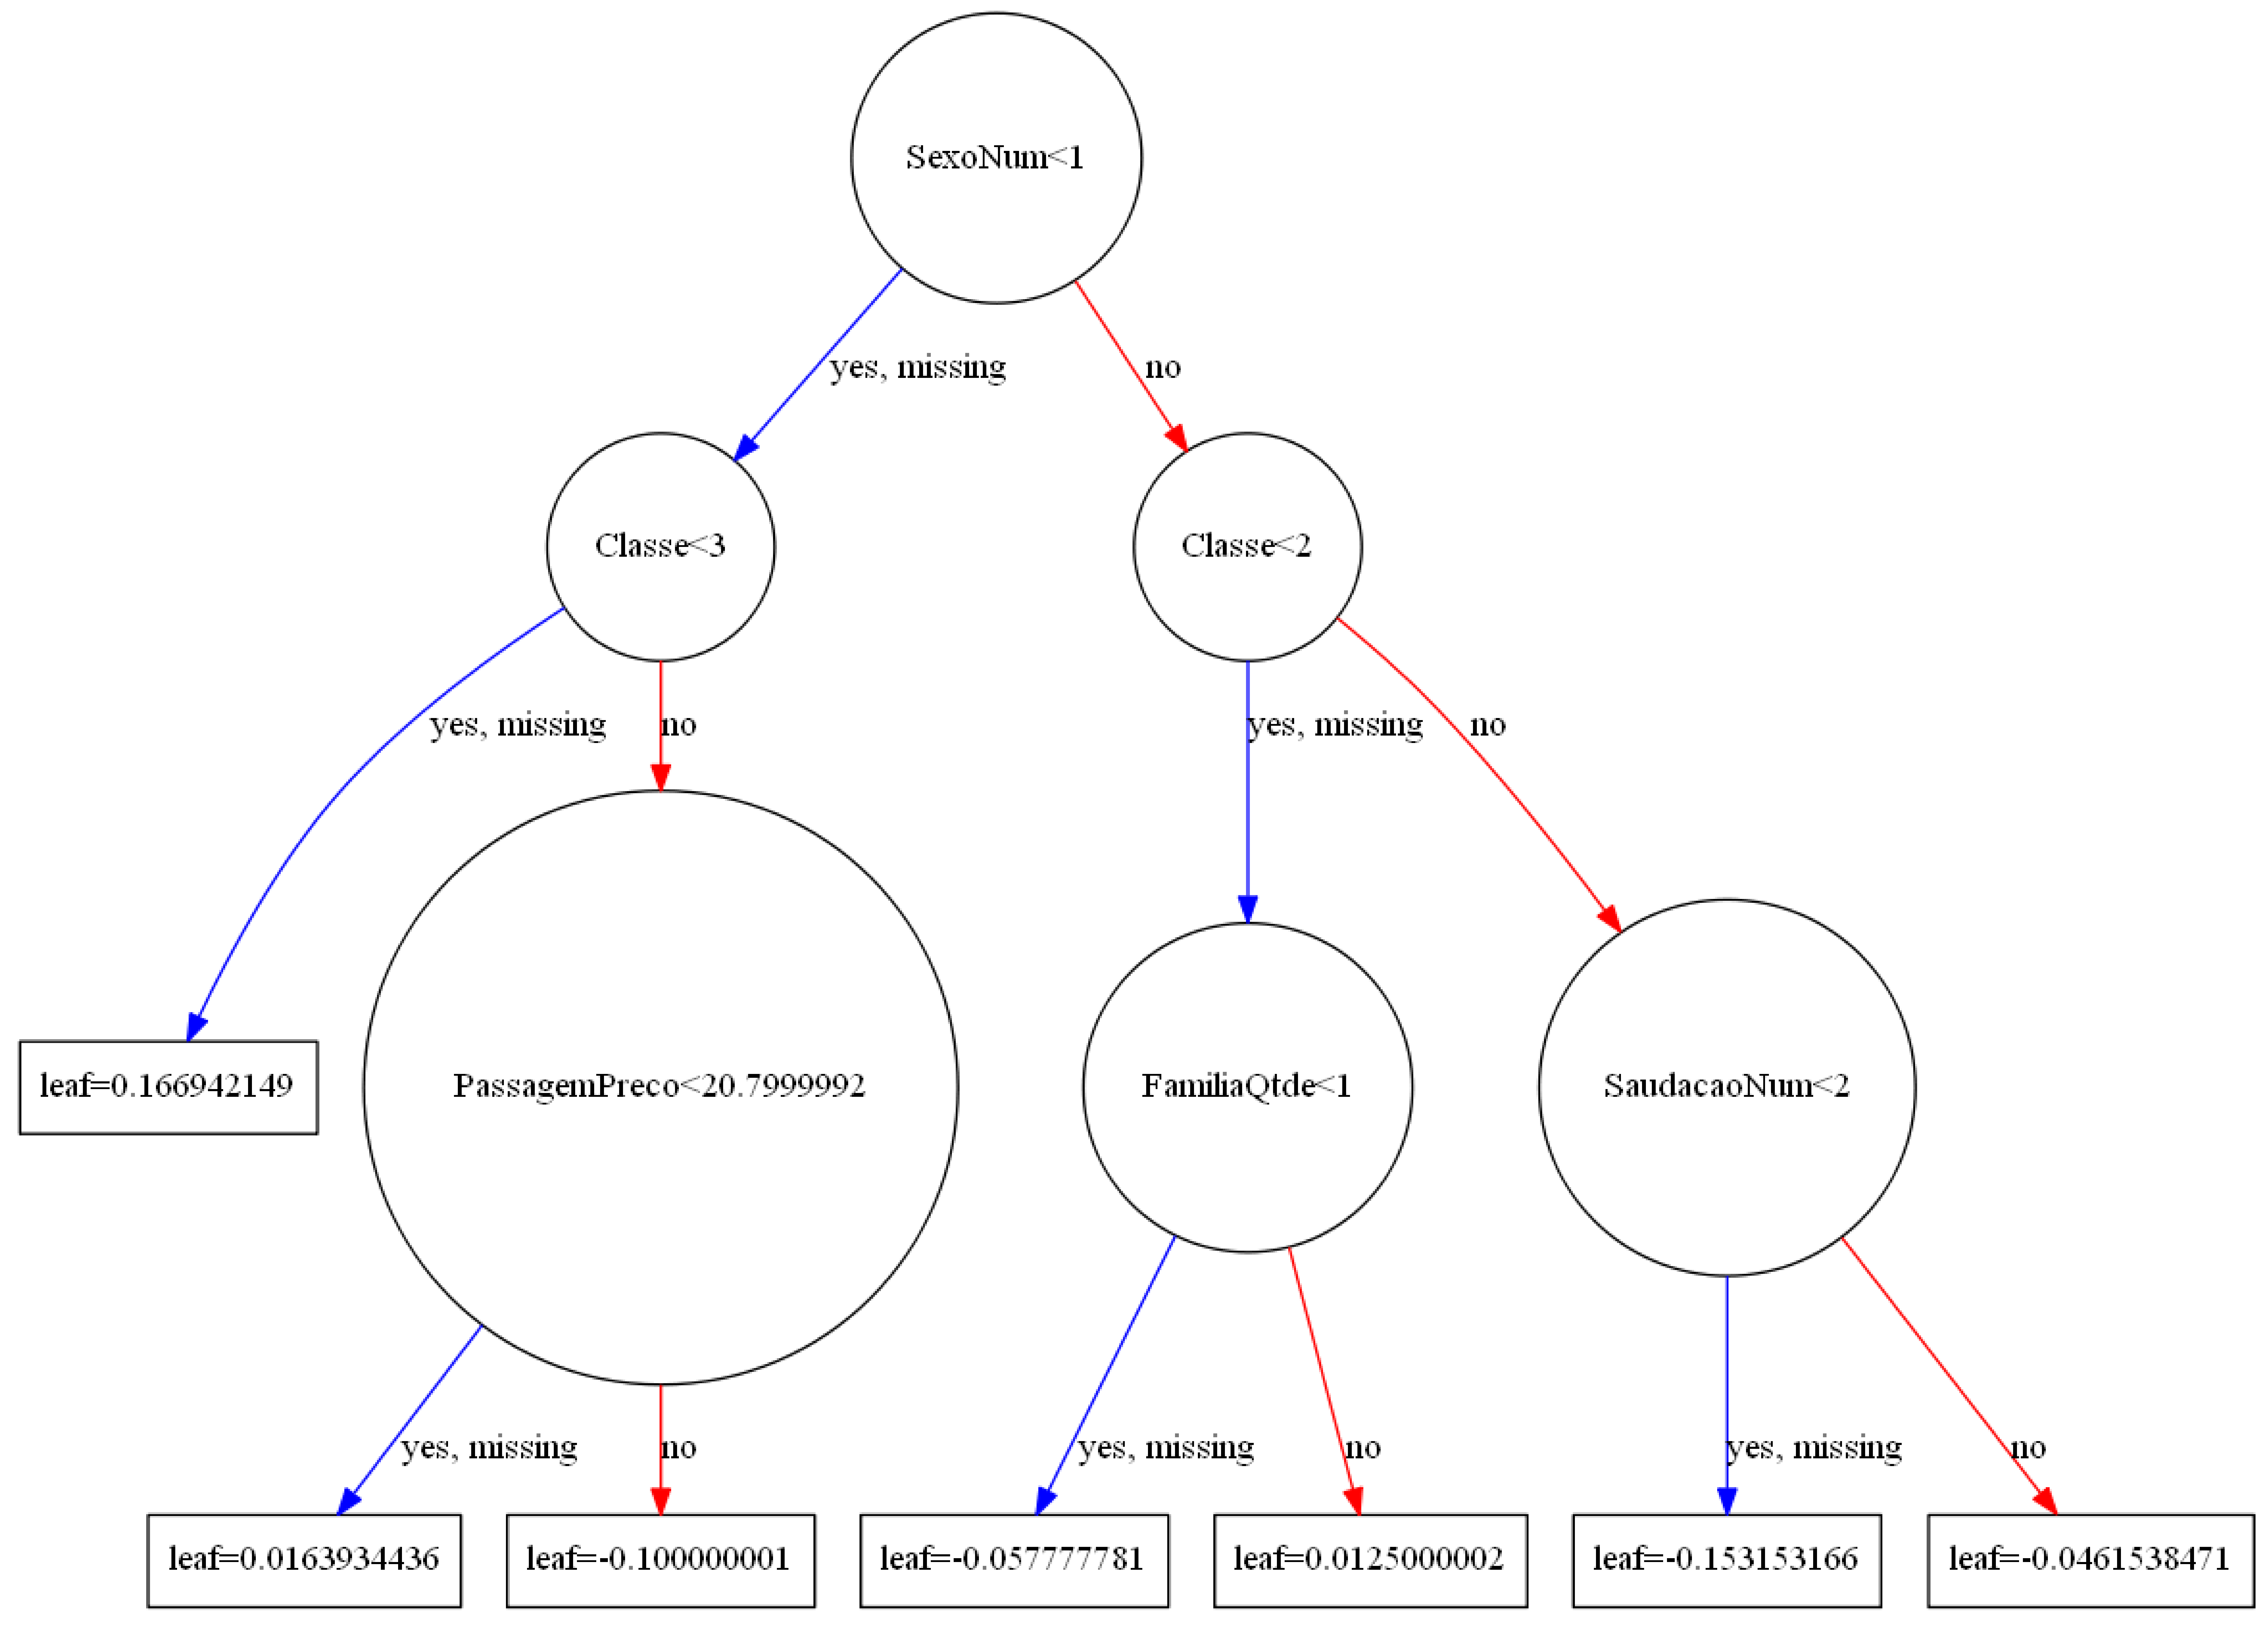

In [56]:
xgb.plot_tree(xgb_model)
fig = pl.gcf()
fig.set_size_inches(150, 100)